In [830]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from copy import deepcopy
import random
import time

import tensorflow as tf
import keras


# %matplotlib notebook
%matplotlib inline

In [952]:
with open('cloud_examples/airplane_no_noise/P.obj') as in_file:
    raw_data = in_file.read()
    
dataP = [list(map(float, row.split(' ')[1:])) for row in raw_data.split('\n')][:-1]

with open('cloud_examples/airplane_no_noise/Q.obj') as in_file:
    raw_data = in_file.read()
    
dataQ = [list(map(float, row.split(' ')[1:])) for row in raw_data.split('\n')][:-1]

In [953]:
Q = np.array(dataQ)
P = np.array(dataP)

## Ищем дисперсию и обратное средннеквадратичное отклонение

In [33]:
p_mean = np.array([P[:,0].mean(), P[:,1].mean(), P[:,2].mean()])

In [49]:
n = P.shape[0]
n

1024

In [58]:
sigma = np.array([np.sqrt(np.sum((P[:, i] - p_mean[i])**2) /n) for i in range(0, 3)])
sigma

array([0.24251311, 0.46149122, 0.0741362 ])

In [57]:
b = 1/sigma
b

array([ 4.12348835,  2.16688845, 13.48868751])

## Строим слой сети

In [59]:
from keras.layers import Layer
from keras import backend as K

In [498]:
class RBFLayer(keras.layers.Layer):
    def __init__(self, input_dim=3, point_count=1024):
        super().__init__()
        self.w = self.add_weight(
            shape=(point_count, input_dim), initializer="random_normal", trainable=True
        )

    def call(self, p):
        """
        inputs = p
        """
        self.culc_b(p)
        diff = p - self.w
        l2 = tf.sqrt(tf.reduce_sum(tf.pow(diff, 2), axis=1))
        n1 = l2 * self.b
        return tf.reshape(tf.exp(-tf.pow(n1, 2)), (1, 1024))
    
    def culc_b(self, inputs):
        means = tf.reduce_mean(inputs, axis=0)
        n = inputs.shape[0]
        self.b = tf.sqrt(tf.reduce_sum(tf.pow(tf.pow(tf.sqrt(tf.reduce_sum(tf.pow(inputs - means, 2), axis=0)/n), -1), 2), axis=0))
        

In [666]:
class RBFLayerForQ(keras.layers.Layer):
    def __init__(self, q):
        super().__init__()
        self.w = q

    def call(self, p):
        """
        inputs = p
        """
        self.culc_b(p)
        p = tf.cast(p, tf.float64)
        diff = p - self.w

        
        l2 = tf.sqrt(tf.reduce_sum(tf.pow(diff, 2), axis=1))
        n1 = l2 * self.b
        return tf.reshape(tf.exp(-tf.pow(n1, 2)), (1, 1024))
    
    def culc_b(self, inputs):
        means = tf.reduce_mean(inputs, axis=0)
        n = inputs.shape[0]
        b = tf.sqrt(tf.reduce_sum(tf.pow(tf.pow(tf.sqrt(tf.reduce_sum(tf.pow(inputs - means, 2), axis=0)/n), -1), 2), axis=0))
        self.b = tf.cast(b, tf.float64)

In [762]:
class RBFLayerForAllPoints(keras.layers.Layer):
    def __init__(self, q):
        super().__init__()
        self.IW = tf.constant(np.array([np.copy(q) for i in range(len(q))]))

    def call(self, p):
        """
        inputs = p
        """
        self.culc_b(p)
        
        point_count = len(p)
        p = tf.cast(p, tf.float64)
        res = []
        for i in range(len(p)):
            diff = self.IW[i] - p[i]

            l2 = tf.sqrt(tf.reduce_sum(tf.pow(diff, 2), axis=1))
            n1 = l2 * self.b
            res.append(tf.reshape(tf.exp(-tf.pow(n1, 2)), (1, point_count)))
            
        return tf.constant(np.array(res), dtype=tf.float64, shape=(point_count, point_count))
    
    def culc_b(self, inputs):
        means = tf.reduce_mean(inputs, axis=0)
        n = inputs.shape[0]
        b = tf.sqrt(tf.reduce_sum(tf.pow(tf.pow(tf.sqrt(tf.reduce_sum(tf.pow(inputs - means, 2), axis=0)/n), -1), 2), axis=0))
        self.b = tf.cast(b, tf.float64)
        


In [763]:
class CompetitiveLayer(keras.layers.Layer):
    def __init__(self, input_dim=1, point_count=1024):
        super().__init__()
        self.w = self.build_w(point_count)

    def call(self, a1):
        a1 = tf.cast(a1, tf.float64)
        return tf.nn.relu(tf.matmul(a1, self.w))
    
    def build_w(self, point_count):
        w_array = np.ones((point_count, point_count))
        for i in range(point_count):
            for j in range(point_count):
                if i == j:
                    continue
                w_array[i, j] = -1/(point_count - 1)
                
        return tf.constant(w_array, dtype='float64')

In [848]:
class CompetitiveLayerForAllPoints(keras.layers.Layer):
    def __init__(self, input_dim=1, point_count=1024):
        super().__init__()
        self.w = self.build_w(point_count)

    def call(self, a1):
        point_count = self.w.shape[0]
        a1 = tf.cast(a1, tf.float64)
        res = []
#         for i in range(len(a1)):
#             reshaped_a = tf.reshape(a1[i], (1, point_count))
#             res.append(tf.nn.relu(tf.matmul(reshaped_a,  self.w)))

        reshaped_a = tf.reshape(a1, (point_count, 1, point_count))            
        res = tf.nn.relu(tf.matmul(reshaped_a,  self.w))

#         return tf.constant(np.array(res), dtype='float64', shape=(point_count, point_count))
        return tf.reshape(res, shape=(point_count, point_count))
    
    def build_w(self, point_count):
        w_array = np.ones((point_count, point_count))
        for i in range(point_count):
            for j in range(point_count):
                if i == j:
                    continue
                w_array[i, j] = -1/(point_count - 1)
                
        return tf.constant(w_array, dtype='float64')

In [887]:
rbf_layer = RBFLayerForAllPoints(q)
y_all = rbf_layer(p)
y_all.shape

TensorShape([1024, 1024])

In [888]:
rbf_layer = RBFLayerForQ(q)
y = rbf_layer(p)
y

<tf.Tensor: shape=(1, 1024), dtype=float64, numpy=
array([[3.98177406e-38, 2.26444306e-23, 4.96082477e-33, ...,
        2.93109074e-26, 1.04523635e-22, 5.23556013e-23]])>

In [889]:
com_layer = CompetitiveLayer(1, 1024)

In [890]:
com_layer_all = CompetitiveLayerForAllPoints(1, 1024)

In [891]:
test_all = com_layer_all(y_all)
test_all

<tf.Tensor: shape=(1024, 1024), dtype=float64, numpy=
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.38350049e-12, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])>

In [845]:
test = com_layer(y)
test

<tf.Tensor: shape=(1, 1024), dtype=float64, numpy=array([[0., 0., 0., ..., 0., 0., 0.]])>

In [934]:
def count_zeros(tensor):
    return 1024 - tf.math.count_nonzero(tensor, axis=1)
    
def count_nozeros(tensor):
    return tf.math.count_nonzero(tensor, axis=1)

In [899]:
zeros = count_nozeros(test_all)
zeros

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([16,  7, 12, ..., 14, 30, 12])>

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [897]:
test_all = com_layer_all(test_all)
zeros = count_nozeros(test_all)
tf.reduce_min(zeros, axis=0)

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [865]:
start_time = time.time()

for i in range(100):
    test_all = com_layer_all(test_all)
    
zeros = count_nozeros(test_all)
print("--- %s seconds ---" % (time.time() - start_time))
zeros

--- 2.8940060138702393 seconds ---


<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 4, 3])>

In [901]:
start_time = time.time()
zeros = count_nozeros(test_all)
i = 0

while tf.reduce_sum(zeros, axis=0) > 1024:
    test_all = com_layer_all(test_all)
    zeros = count_nozeros(test_all)   
    i+=1

print("--- %s seconds ---" % (time.time() - start_time))
zeros

--- 55.076467990875244 seconds ---


<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [902]:
tf.reduce_sum(zeros, axis=0), i

(<tf.Tensor: shape=(), dtype=int64, numpy=1024>, 1800)

In [822]:
zeros = calc_zeros(test_all)
zeros

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1021, 1022, 1021, ..., 1021, 1020, 1021])>

In [875]:
for i in zeros:
    print(i)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype

In [568]:
test

<tf.Tensor: shape=(1, 1024), dtype=float64, numpy=
array([[1.95439274e-19, 1.95461805e-19, 1.95439274e-19, ...,
        1.95439300e-19, 1.95543287e-19, 1.95491374e-19]])>

In [608]:
test = com_layer(test)
len([i.numpy() for i in test[0] if i.numpy() == 0])
# test

1007

In [617]:
for i in range(100):
    test = com_layer(test)

len([i.numpy() for i in test[0] if i.numpy() == 0])


1023

## Проверим сопоставление точек

In [903]:
matching_points = np.copy(test_all)

In [904]:
for i in test_all[0]:
    print(i)

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)


In [905]:
def find_points(probabilities):
    for i in range(len(probabilities)):
        for j in range(len(probabilities)):
            if probabilities[i][j] != 0:
                yield (i, j)
        
list(find_points(matching_points))

[(0, 493),
 (1, 193),
 (2, 976),
 (4, 752),
 (5, 286),
 (6, 70),
 (7, 223),
 (8, 827),
 (9, 903),
 (10, 1013),
 (11, 948),
 (12, 667),
 (13, 205),
 (14, 903),
 (15, 875),
 (16, 875),
 (17, 976),
 (18, 223),
 (19, 286),
 (20, 736),
 (21, 130),
 (22, 223),
 (22, 1013),
 (23, 493),
 (24, 400),
 (25, 130),
 (26, 505),
 (27, 193),
 (28, 286),
 (29, 241),
 (32, 661),
 (33, 903),
 (34, 903),
 (35, 162),
 (35, 532),
 (36, 505),
 (37, 193),
 (38, 661),
 (39, 452),
 (39, 457),
 (40, 875),
 (40, 1013),
 (42, 1013),
 (43, 193),
 (44, 875),
 (45, 241),
 (46, 661),
 (47, 691),
 (48, 903),
 (49, 505),
 (50, 1013),
 (51, 241),
 (51, 532),
 (52, 875),
 (53, 578),
 (54, 359),
 (54, 840),
 (55, 667),
 (56, 875),
 (57, 1007),
 (58, 286),
 (59, 193),
 (60, 736),
 (61, 661),
 (61, 1013),
 (62, 286),
 (63, 903),
 (64, 223),
 (65, 750),
 (66, 241),
 (67, 1013),
 (68, 948),
 (69, 570),
 (70, 177),
 (71, 976),
 (72, 505),
 (73, 223),
 (74, 661),
 (75, 511),
 (76, 903),
 (77, 1004),
 (78, 193),
 (78, 286),
 (79,

In [879]:
def find_i(probabilities):
    for i in range(len(probabilities)):
        if probabilities[i] != 0:
            return i

In [880]:
find_i(matching_points[0])

493

In [906]:
P[0]

array([0.056, 0.367, 0.087])

In [907]:
Q[493]

array([-0.082609  ,  0.00357279,  0.247861  ])

In [886]:
min_len = 99999
min_i = 9999
for i in range(1024):
    if min_len > np.linalg.norm(Q[0] - P[i]):
        min_len = np.linalg.norm(Q[0] - P[i])
        min_i = i
        
min_len, min_i

(0.2897222132905932, 69)

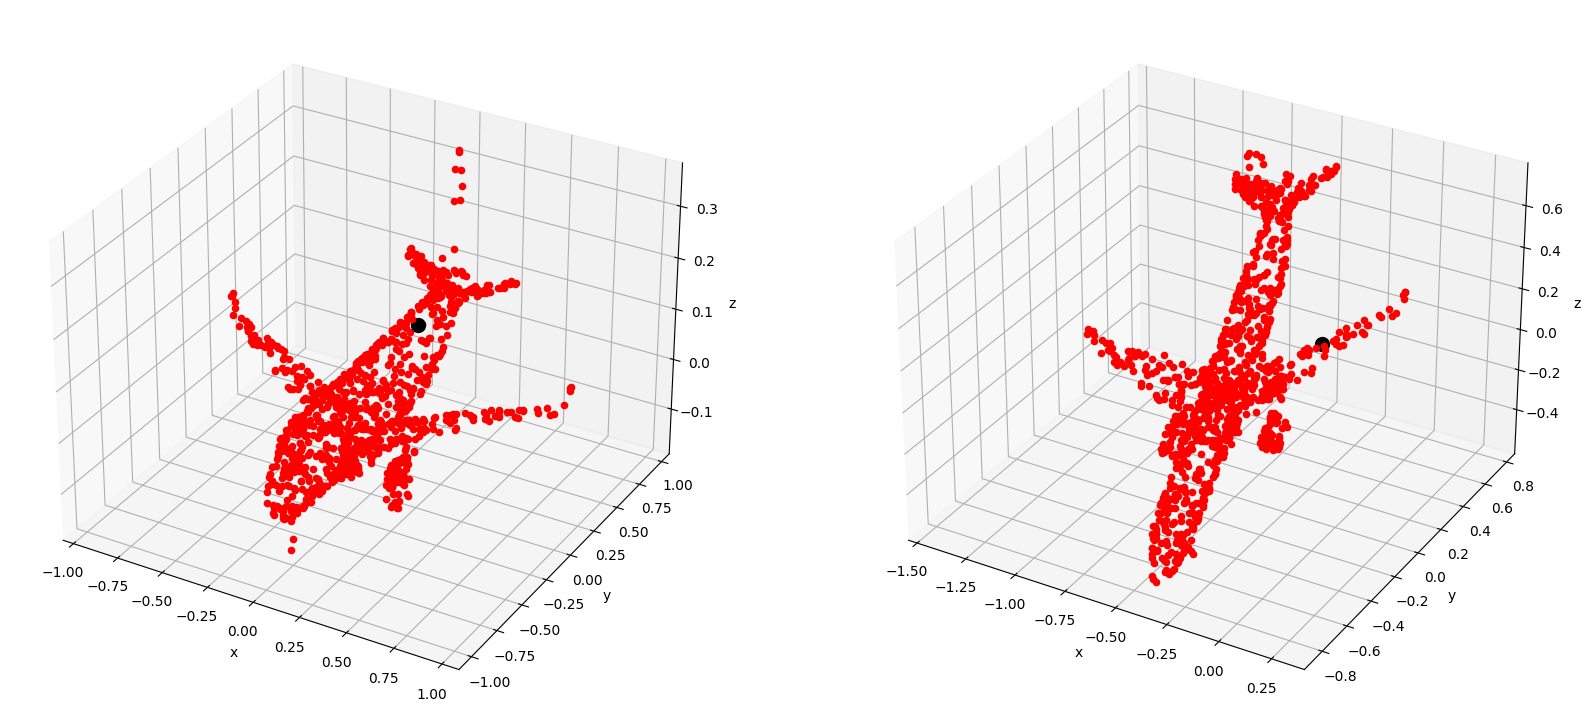

In [908]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for point in P:
    ax.scatter3D(*point, color='red')
    
ax.scatter3D(*P[0], color='black', s=100)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
for point in Q:
    ax.scatter3D(*point, color='red')

ax.scatter3D(*Q[493], color='black', s=100)
None

In [ ]:
R = normTransQ @ transP.T @ np.linalg.inv(transP @ transP.T)

## Sandbox

In [496]:
q = tf.constant(Q)
q

<tf.Tensor: shape=(1024, 3), dtype=float64, numpy=
array([[-0.552865  ,  0.24598   ,  0.280693  ],
       [-0.316073  ,  0.0695407 , -0.00655038],
       [-0.630708  ,  0.200029  ,  0.19348   ],
       ...,
       [-0.324171  , -0.00459492,  0.066088  ],
       [-0.582059  , -0.0138649 , -0.074342  ],
       [-0.454034  , -0.370308  , -0.318585  ]])>

In [497]:
p = tf.constant(P, dtype='float64')
p

<tf.Tensor: shape=(1024, 3), dtype=float64, numpy=
array([[ 0.056,  0.367,  0.087],
       [ 0.174,  0.036, -0.128],
       [-0.045,  0.293,  0.077],
       ...,
       [ 0.204,  0.013, -0.031],
       [-0.086, -0.034, -0.029],
       [-0.03 , -0.479, -0.073]])>

In [287]:
p - q

<tf.Tensor: shape=(1024, 3), dtype=float64, numpy=
array([[ 0.608865  ,  0.12102   , -0.193693  ],
       [ 0.490073  , -0.0335407 , -0.12144962],
       [ 0.585708  ,  0.092971  , -0.11648   ],
       ...,
       [ 0.528171  ,  0.01759492, -0.097088  ],
       [ 0.496059  , -0.0201351 ,  0.045342  ],
       [ 0.424034  , -0.108692  ,  0.245585  ]])>

In [420]:
qwer = tf.constant([[2]], dtype='double')

In [421]:
q * qwer

<tf.Tensor: shape=(1024, 3), dtype=float64, numpy=
array([[-1.10573   ,  0.49196   ,  0.561386  ],
       [-0.632146  ,  0.1390814 , -0.01310076],
       [-1.261416  ,  0.400058  ,  0.38696   ],
       ...,
       [-0.648342  , -0.00918984,  0.132176  ],
       [-1.164118  , -0.0277298 , -0.148684  ],
       [-0.908068  , -0.740616  , -0.63717   ]])>

In [619]:
np.copy(np.array([1, 2, 3]))

array([1, 2, 3])

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.056, 0.367, 0.087])>

In [621]:
p - p[0]

<tf.Tensor: shape=(1024, 3), dtype=float64, numpy=
array([[ 0.   ,  0.   ,  0.   ],
       [ 0.118, -0.331, -0.215],
       [-0.101, -0.074, -0.01 ],
       ...,
       [ 0.148, -0.354, -0.118],
       [-0.142, -0.401, -0.116],
       [-0.086, -0.846, -0.16 ]])>

In [787]:
tf.matmul(tf.constant(np.ones((1, 3))), tf.constant(np.ones((3, 3))))


<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[3., 3., 3.]])>

In [788]:
tf.math.count_nonzero(test_all, axis=1)

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([20,  9, 17, ..., 16, 44, 18])>

In [805]:
dsgndf = tf.constant(np.ones((1, 3)))

In [954]:
x, y, z = [_[0] for _ in Q], [_[1] for _ in Q], [_[2] for _ in Q]
x = sum(x)/len(x)
y = sum(y)/len(y)
z = sum(z)/len(z)

middle_q = [x, y, z]

x, y, z = [_[0] for _ in P], [_[1] for _ in P], [_[2] for _ in P]
x = sum(x)/len(x)
y = sum(y)/len(y)
z = sum(z)/len(z)

middle_p = [x, y, z]

sorted_p = sorted(P, key=lambda _: np.linalg.norm(_) - np.linalg.norm(middle_p), reverse=True)
sorted_q = sorted(Q, key=lambda _: np.linalg.norm(_) - np.linalg.norm(middle_q), reverse=True)

farthest_point_q = Q[0]
max_len_q = np.linalg.norm(farthest_point_q - middle_q)

for point in Q:
    norm = np.linalg.norm(point - middle_q)
    if norm > max_len_q:
        farthest_point_q = point
        max_len_q = norm
        

        
farthest_point_p = P[0]
max_len_p = np.linalg.norm(farthest_point_p - middle_p)

for point in P:
    norm = np.linalg.norm(point - middle_p)
    if norm > max_len_p:
        farthest_point_p = point
        max_len_p = norm

In [955]:
norm_Q = np.array([_ - middle_q for _ in Q])
norm_P = np.array([_ - middle_p for _ in P])

In [956]:
norm_rbf_layer = RBFLayerForAllPoints(norm_P)
norm_y = rbf_layer(norm_Q)
norm_y.shape

TensorShape([1024, 1024])

In [957]:
norm_com_layer = CompetitiveLayerForAllPoints(1, 1024)
norm_test = com_layer_all(norm_y)
norm_test

<tf.Tensor: shape=(1024, 1024), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01962934],
       [0.06607436, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02865328],
       [0.        , 0.15930377, 0.        , ..., 0.01532132, 0.00252301,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])>

In [958]:
start_time = time.time()
norm_zeros = count_nozeros(norm_test)
i = 0

while tf.reduce_sum(norm_zeros, axis=0) > 1024:
    norm_test = norm_com_layer(norm_test)
    norm_zeros = count_nozeros(norm_test)   
    i+=1

print("--- %s seconds ---" % (time.time() - start_time))
norm_zeros

--- 159.00927996635437 seconds ---


<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [959]:
norm_test

<tf.Tensor: shape=(1024, 1024), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [960]:
norm_probabilities = np.copy(norm_test)
def find_points(probabilities):
    for i in range(len(probabilities)):
        for j in range(len(probabilities)):
            if probabilities[i][j] != 0:
                yield (i, j)
        
list(find_points(norm_probabilities))

[(0, 244),
 (1, 836),
 (2, 202),
 (3, 310),
 (4, 263),
 (5, 670),
 (6, 86),
 (7, 493),
 (8, 990),
 (9, 598),
 (10, 286),
 (11, 234),
 (12, 580),
 (13, 13),
 (14, 828),
 (15, 223),
 (16, 687),
 (17, 678),
 (18, 86),
 (19, 422),
 (20, 350),
 (21, 429),
 (22, 1023),
 (23, 375),
 (24, 422),
 (25, 735),
 (26, 571),
 (27, 107),
 (28, 86),
 (29, 1018),
 (30, 22),
 (31, 733),
 (32, 903),
 (33, 118),
 (34, 286),
 (35, 735),
 (36, 505),
 (37, 88),
 (38, 938),
 (39, 314),
 (40, 602),
 (41, 526),
 (42, 828),
 (43, 71),
 (44, 435),
 (45, 996),
 (46, 209),
 (47, 40),
 (48, 848),
 (49, 745),
 (50, 209),
 (51, 230),
 (52, 505),
 (53, 818),
 (54, 997),
 (55, 619),
 (56, 825),
 (57, 537),
 (58, 952),
 (59, 470),
 (60, 154),
 (61, 968),
 (62, 828),
 (63, 670),
 (64, 870),
 (65, 154),
 (66, 836),
 (67, 113),
 (68, 263),
 (69, 173),
 (70, 223),
 (71, 193),
 (72, 614),
 (73, 463),
 (74, 125),
 (75, 310),
 (76, 223),
 (77, 726),
 (78, 923),
 (79, 828),
 (80, 505),
 (81, 825),
 (82, 270),
 (83, 86),
 (84, 481

In [947]:
norm_Q[1]

array([ 0.20392334,  0.0795574 , -0.00653525])

In [948]:
norm_P[762]

array([ 0.23300098,  0.05602246, -0.03199609])

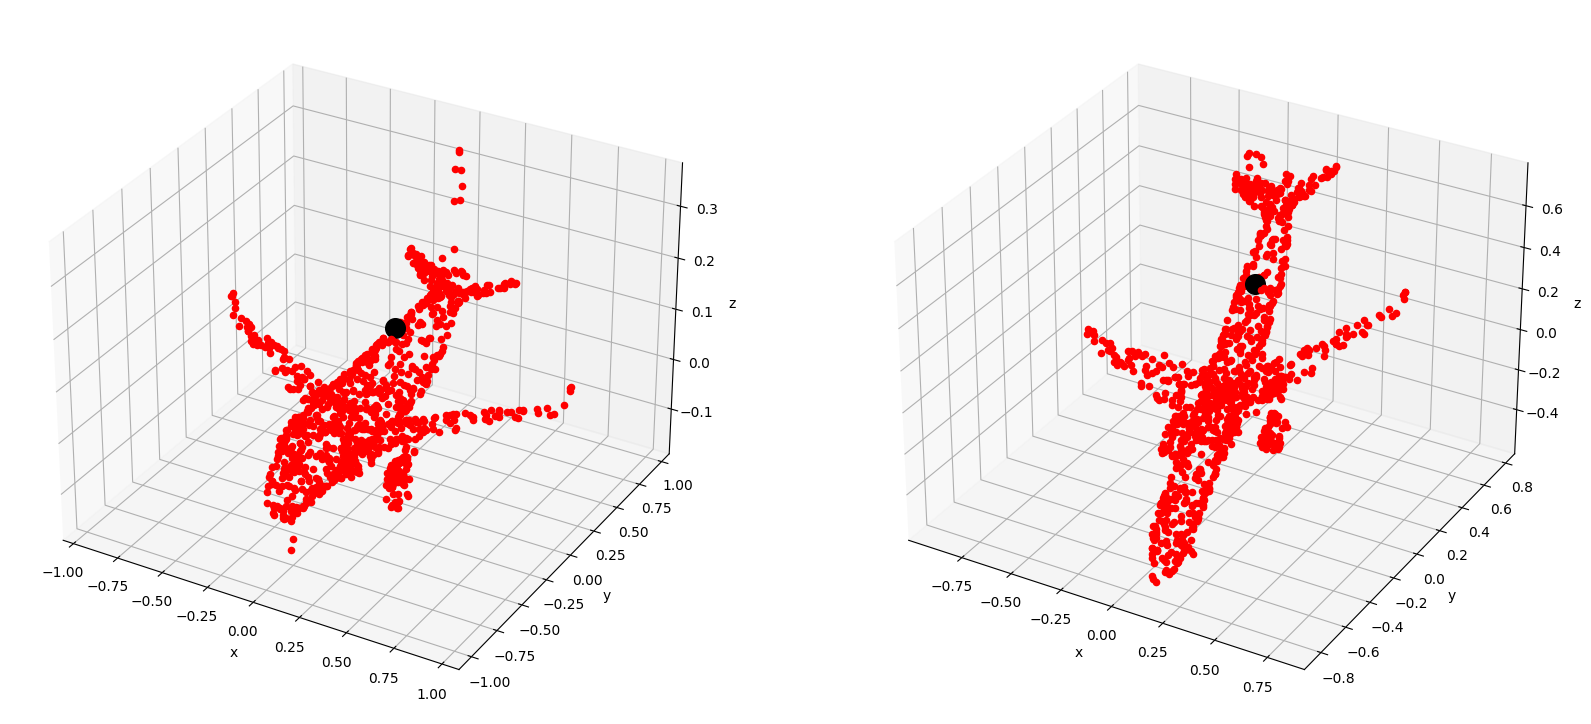

In [951]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for point in norm_P:
    ax.scatter3D(*point, color='red')
    
ax.scatter3D(*norm_P[530], color='black', s=200)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
for point in norm_Q:
    ax.scatter3D(*point, color='red')

ax.scatter3D(*norm_Q[0], color='black', s=200)
None